In [1]:
# Titanic dataset : prediction of people survived using Logistic Regression
# Date Created : 10/10/2016
# Created by : Harshad Lalit 

# Reading and Data Processing

In [2]:
import numpy as np
import pandas as pd
import scipy
import warnings

warnings.filterwarnings("ignore")
titanic_train = pd.read_csv('../Kaggle-Titanic/train.csv')

#NAN's in the Age column 
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
# Features to be used to determine passenger survivability:
# 1. Pclass 
# 2. Sex 
# 3. Age
# 4. SibSp
# 5. Parch
# 6. Fare
# 7. Embarked

# Convert Sex column to numeric: Male - 1, Female - 0
titanic_train.loc[titanic_train.Sex == 'male','Sex'] = 1
titanic_train.loc[titanic_train.Sex == 'female','Sex'] = 0

# fill the NAN values in the Age column with the mean of the Age column
titanic_train['Age'] = titanic_train['Age'].fillna(titanic_train['Age'].mean())

# Obtain unique values of the Embarked column
titanic_train['Embarked'].unique()

# Category S is the most in the Embarked column
temp = titanic_train.groupby(titanic_train['Embarked'])
temp.describe() 

#converting nan value to S; also converting S, C and Q to numeric values
titanic_train['Embarked'] = titanic_train['Embarked'].fillna('S')
titanic_train.loc[titanic_train.Embarked == 'S','Embarked'] = 1
titanic_train.loc[titanic_train.Embarked == 'C','Embarked'] = 2
titanic_train.loc[titanic_train.Embarked == 'Q','Embarked'] = 3

In [4]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1


# Data Visualization

In [5]:
import matplotlib.pyplot as plt

# show plots in the notebook
%matplotlib inline

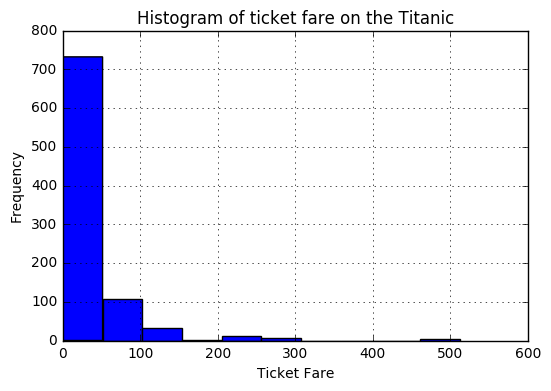

In [6]:
# histogram of Ticket Fare
plt.figure(1)
titanic_train['Fare'].hist()
plt.title('Histogram of ticket fare on the Titanic')
plt.xlabel('Ticket Fare')
plt.ylabel('Frequency')
plt.show()

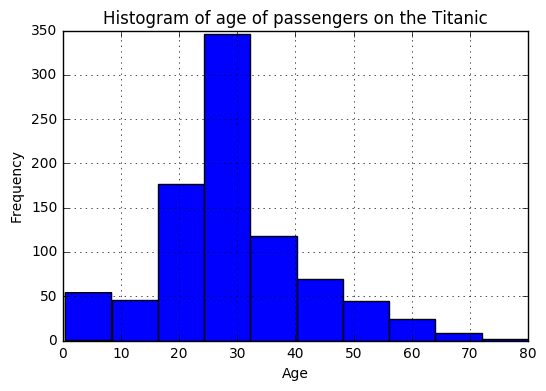

In [7]:
# histogram of Age
plt.figure(2)
titanic_train['Age'].hist()
plt.title('Histogram of age of passengers on the Titanic')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

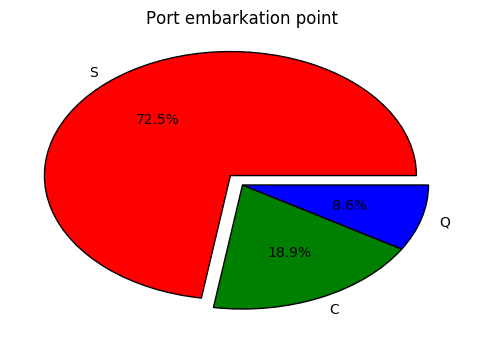

In [8]:
# number_embarked is a pandas series, not a dataframe
number_embarked = titanic_train.groupby('Embarked').size() 

slices = [number_embarked.iloc[0],number_embarked.iloc[1],number_embarked.iloc[2]]
labs = ['S','C','Q']
cols = ['r','g','b']

#pie chart to show which port is the most popular for embarking on the Titanic
plt.figure(3)
plt.pie(slices, 
        labels=labs, 
        colors=cols, 
        explode=(0.1,0,0),
        autopct='%1.1f%%')

plt.title('Port embarkation point')
plt.show()

# Logistic Regression on Training Data

In [9]:
# preparing data for utilising on the training set
# copying the necessary features into new dataframe
train = titanic_train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

#making all the columns of the dataframe of the same dtype - float
train.loc[:,:] = train.loc[:,:].astype('float64')
train_nn = train.copy()

max_arr = np.array([0,3,4,6]) #calculated manually 
mean_arr = np.array([2,5]) #calculated manually 

for i in max_arr:
    maxi = np.max(train.iloc[:,i])
    train.iloc[:,i] = train.iloc[:,i]/maxi
    
for i in mean_arr:
    avg = np.mean(train.iloc[:,i])
    var = np.std(train.iloc[:,i])
    train.iloc[:,i] = (train.iloc[:,i] - avg)/var

    
#convert dataframe of training data into numpy 2D matrix 
train = train.as_matrix()

#returns tuple where 1st element is rows and 2nd the columns
dim = train.shape
m = dim[0]
n = dim[1] + 1

#convert labels into array (mx1)
labels = np.zeros(m)
labels[:] = titanic_train['Survived'].iloc[:]

#adding a column of 1's to the training set (xo = 1) (train ~ mx(n+1))
one = np.ones([dim[0],1])
train = np.c_[one,train]

#size of theta = number of features + 1 (n) - array of size nx1
theta = np.zeros(n)
lda = 2.0

In [10]:
import math as mt 

#sigmoid function for returning the value of hypothesis function : h(x) 
def sigmoid(z):
    
    h = 1/(1 + np.exp(-z))
    return h

In [11]:
#function to return the cost function at every iteration of the gradient descent
def cost_function(theta):
    
    s = 0.0
    z = np.dot(train, theta)
    thetap = theta
    thetap = thetap.tolist()
    thetap.remove(thetap[0])
    thetap = np.array(thetap)
    h = sigmoid(z)
    
    cost = -np.dot(np.transpose(labels),np.log(h)) - np.dot(np.transpose(1 - labels),np.log(1 - h))
    cost = cost + (0.5*lda/m)*np.sum(thetap**2)
    cost = cost/m
            
    return cost

In [12]:
#Script for obtaining values of parameters theta by minimising the cost function J(theta)
#learning rate(alpha) = 0.01
#number of iterations = 2000

def gradient_cost_function(theta):
    
    m = dim[0] #number of training examples
    n = dim[1] + 1 #number of features
    dummy = np.zeros(m) #array of size mx1 
    grad = np.zeros(n)

    z = np.dot(train, theta)
    h = sigmoid(z)
    
    dummy = h - labels
                
#     grad = (1/m)*np.dot(np.transpose(train),dummy)
    for i in range(0,n):
        if(i == 0):
            grad[0] = (1/m)*np.dot(train[:,0],dummy)
        if(i != 0):
            grad[i] = (1/m)*np.dot(train[:,i],dummy) + (lda/m)*theta[i]
        
    return grad

In [13]:
from scipy import optimize
theta = scipy.optimize.fmin_bfgs(cost_function, theta, gradient_cost_function)
print(theta)

         Current function value: 0.445571
         Iterations: 28
         Function evaluations: 119
         Gradient evaluations: 107
[ 2.74381126 -2.51715897 -2.4644324  -0.41785621 -1.24395013 -0.51241453
  0.19085684  0.61261064]


In [14]:
#calculate the prediction accuracy of the logistic regression

z = np.dot(train, theta)
predictions = sigmoid(z)

predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

count = 1
for i in range(0,m):
    if(labels[i]==predictions[i]):
        count = count + 1

accuracy = count/m
print("Prediction accuracy is:",accuracy*100,"%")

Prediction accuracy is: 80.13468013468014 %


# Neural Network on Training Data

In [15]:
max_arr = np.array([0,3,4,6]) #calculated manually 
mean_arr = np.array([2,5]) #calculated manually 

for i in max_arr:
    maxi = np.max(train_nn.iloc[:,i])
    train_nn.iloc[:,i] = train_nn.iloc[:,i]/maxi
    
for i in mean_arr:
    avg = np.mean(train_nn.iloc[:,i])
    var = np.std(train_nn.iloc[:,i])
    train_nn.iloc[:,i] = (train_nn.iloc[:,i] - avg)/var

train_nn = train_nn.as_matrix()
train_nn = np.c_[one,train_nn]

In [16]:
nlayers = 3
ielements = []
btheta_init = []      #list to compute theta at every layer 
ntheta = []           #list to enter size of theta at every layer
theta_reshape = []
einit = 0.44

for k in range(0,nlayers): #number of elements is the same in every layer = n - 1 (+ bias unit)
    ielements.append(n-1)

#initializing the value of weights (theta) vector 
for k in range(0,nlayers-1):
    theta_nn = np.random.rand(ielements[k+1],ielements[k]+1)*2*einit - einit
    
    if(k == nlayers - 2):
        theta_nn = np.random.rand(ielements[k]+1)*2*einit - einit
        
    btheta_init.append(theta_nn)
    ntheta.append(btheta_init[k].size)

size_btheta = len(btheta_init)

for k in range(0,size_btheta):
    theta_reshape.append(np.reshape(btheta_init[k],btheta_init[k].size))
    
theta_reshape = np.concatenate((theta_reshape[0],theta_reshape[1])) #need to find a generalization statement !
theta_reshape = theta_reshape.astype(float)

In [17]:
#sigmoid function for returning the value of hypothesis function : h(x) 
def sigmoid(z):
    
    h = 1.0/(1.0 + np.exp(-z))
    return h

In [18]:
#function to return the cost function at every iteration of the gradient descent
def cost_function_nn(theta_reshape):
   
    btheta  = []
    cost = float(0.0)
    for k in range(0,size_btheta):
        tmp1 = ntheta[:k]
        tmp2 = ntheta[:k+1]
        LL = np.sum(tmp1)
        UL = np.sum(tmp2) 
        tmp = theta_reshape[LL:UL]
        
        if(k == size_btheta - 1):
            tmp = np.reshape(tmp,ielements[k]+1)
        else:
            tmp = np.reshape(tmp,(ielements[k+1],ielements[k]+1))   
        btheta.append(tmp)
    
    for t in range(0,m):
        a = []
        delta = []
        a.append(train_nn[t,:])
        
        #forward propagation (tp is a temporary variable)
        for l in range(1,nlayers):
            tp = np.dot(btheta[l-1],a[l-1])
            tp = sigmoid(tp)
            
            if(l != nlayers-1):
                tp = np.insert(tp,0,1.0) #insert the element 1 in front of feature vector at layer j
            a.append(tp)
        
        cost = cost + labels[t]*np.log(a[nlayers-1]) + (1-labels[t])*(1-np.log(a[nlayers-1]))
        
    cost = (-1.0/m)*cost
    return cost 

In [19]:
def gradient_cost_function_nn(theta_reshape):
    
    btheta  = []
    Dij = []         #list to compute gradient of theta at every layer
    nabla = []       #accumulator list to compute the gradient of theta at every layer
    for k in range(0,size_btheta):
        tmp1 = ntheta[:k]
        tmp2 = ntheta[:k+1]
        LL = np.sum(tmp1)
        UL = np.sum(tmp2) 
        tmp = theta_reshape[LL:UL]
        
        if(k == size_btheta - 1):
            tmp = np.reshape(tmp,ielements[k]+1)
        else:
            tmp = np.reshape(tmp,(ielements[k+1],ielements[k]+1))   
        btheta.append(tmp)
        
    for k in range(0,size_btheta):
        nabla.append(btheta_init[k]*0.0)
    
    for t in range(0,m): 
        a = []
        delta = []
        a.append(train_nn[t,:])
        
        #forward propagation (tp is a temporary variable)
        for l in range(1,nlayers):
            tp = np.dot(btheta[l-1],a[l-1])
            tp = sigmoid(tp)
            
            if(l != nlayers-1):
                tp = np.insert(tp,0,1) #insert the element 1 in front of feature vector at layer j
            a.append(tp)
        
        #backpropagation (dp is a temporary variable)
        k=0
        for l in range(nlayers-1,0,-1):
            if(l == nlayers-1):
                dp = a[l] - labels[t]
            else:
                dp = np.multiply(np.dot(btheta[l],delta[k]),a[l])
                dp = np.multiply(dp,(1-a[l]))
                dp = dp[1:] #removing the first element of delta array
                k = k + 1
                
            delta.append(dp)
        delta.reverse()
            
        #computing the values of nabla[i]
        for l in range(0,nlayers-1):
            nabla[l] = nabla[l] + np.dot(np.transpose(np.matrix(delta[l])),np.matrix(a[l]))
            nabla[l] = np.asarray(nabla[l])
            
            if(l == nlayers-2):
                nabla[l] = np.reshape(nabla[l],-1)

    for k in range(0,size_btheta):
        Dij.append(nabla[k])
        Dij[k] = Dij[k]/m
    
    grad = []
    for k in range(0,size_btheta):
        grad.append(np.reshape(Dij[k],Dij[k].size))
        
    grad = np.concatenate((grad[0],grad[1])) #need to find a generalization statement !
    grad = grad.astype(float)
    
    return grad

In [20]:
def gradient_check(theta_reshape):
    
    ntot = theta_reshape.shape[0]
    gradtheta = np.zeros(ntot,dtype = float)
    epsilon = 0.0001
    for i in range(0,ntot):
        thetaPlus = theta_reshape
        thetaPlus[i] = thetaPlus[i] + epsilon
        thetaMinus = theta_reshape
        thetaMinus[i] = thetaMinus[i] - epsilon 
        gradtheta[i] = (cost_function_nn(thetaPlus) - cost_function_nn(thetaMinus))/(2.0*epsilon)
    
    return gradtheta

# grad1 = gradient_check(theta_reshape)
# grad2 = gradient_cost_function_nn(theta_reshape)

In [21]:
theta_reshape = scipy.optimize.fmin_bfgs(cost_function_nn, theta_reshape, gradient_cost_function_nn)

         Current function value: -1.171996
         Iterations: 5
         Function evaluations: 106
         Gradient evaluations: 94


In [22]:
#calculate the prediction accuracy of the neural network

btheta  = []
predictions_nn = np.zeros(m)

for k in range(0,size_btheta):
    tmp1 = ntheta[:k]
    tmp2 = ntheta[:k+1]
    LL = np.sum(tmp1)
    UL = np.sum(tmp2) 
    tmp = theta_reshape[LL:UL]
        
    if(k == size_btheta - 1):
        tmp = np.reshape(tmp,ielements[k]+1)
    else:
        tmp = np.reshape(tmp,(ielements[k+1],ielements[k]+1))   
    btheta.append(tmp)
    
for t in range(0,m): 
    a = []
    delta = []
    a.append(train_nn[t,:])
        
    #forward propagation (tp is a temporary variable)
    for l in range(1,nlayers):
        tp = np.dot(btheta[l-1],a[l-1])
        tp = sigmoid(tp)
            
        if(l != nlayers-1):
            tp = np.insert(tp,0,1) #insert the element 1 in front of feature vector at layer j
        a.append(tp)
        
    predictions_nn[t] = a[nlayers-1]

predictions_nn[predictions_nn >= 0.5] = 1
predictions_nn[predictions_nn < 0.5] = 0

count = 1
for i in range(0,m):
    if(labels[i]==predictions_nn[i]):
        count = count + 1

accuracy = count/m
print("Prediction accuracy is:",accuracy*100,"%")

Prediction accuracy is: 64.75869809203144 %


# Evaluating the Test Set

In [23]:
titanic_test = pd.read_csv('../Kaggle-Titanic/test.csv')

In [24]:
titanic_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,NaN,0.000000,0.000000,NaN
50%,1100.500000,3.000000,NaN,0.000000,0.000000,NaN
75%,1204.750000,3.000000,NaN,1.000000,0.000000,NaN
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [25]:
# Convert Sex column to numeric: Male - 1, Female - 0
titanic_test.loc[titanic_test.Sex == 'male','Sex'] = 1
titanic_test.loc[titanic_test.Sex == 'female','Sex'] = 0

# fill the NAN values in the Age column with the mean of the Age column
titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test['Age'].mean())

#Again, category S is the most popular destination for embarking 
temp = titanic_train.groupby(titanic_test['Embarked'])
temp.describe()

#converting nan value to S; also converting S, C and Q to numeric values
titanic_test['Embarked'] = titanic_test['Embarked'].fillna('S')
titanic_test.loc[titanic_test.Embarked == 'S','Embarked'] = 1
titanic_test.loc[titanic_test.Embarked == 'C','Embarked'] = 2
titanic_test.loc[titanic_test.Embarked == 'Q','Embarked'] = 3

#fill the NAN value in the fare column with the mean of the fare column
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Fare'].mean())

In [26]:
print(titanic_test.dtypes)

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [27]:
test = titanic_test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
test.loc[:,:] = test.loc[:,:].astype('float64')
test.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.636364,30.272590,0.447368,0.392344,35.627188,1.464115
std,0.841838,0.481622,12.634534,0.896760,0.981429,55.840500,0.685516
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,1.000000
50%,3.000000,1.000000,30.272590,0.000000,0.000000,14.454200,1.000000
75%,3.000000,1.000000,35.750000,1.000000,0.000000,31.500000,2.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,3.000000


In [28]:
#convert dataframe into 2d matrix 
test = test.as_matrix()
m_test = test.shape[0]

#adding a column of 1's to the test matrix
one = np.ones([m_test,1])
test = np.c_[one,test]

z = np.dot(test, theta)
test_predictions = sigmoid(z)
test_predictions[test_predictions >= 0.5] = 1
test_predictions[test_predictions <= 0.5] = 0 

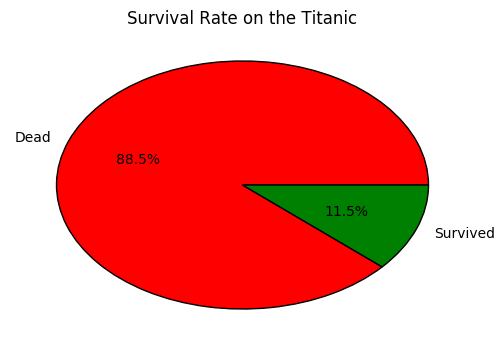

In [29]:
from scipy import stats
freq = scipy.stats.itemfreq(test_predictions)

slices = [freq[0][1],freq[1][1]]
labs = ['Dead','Survived']
cols = ['r','g']

#pie chart to show which port is the most popular for embarking on the Titanic
plt.figure(4)
plt.pie(slices, 
        labels=labs, 
        colors=cols, 
        autopct='%1.1f%%')

plt.title('Survival Rate on the Titanic')
plt.show()

In [30]:
submission = pd.DataFrame({"PassengerID":titanic_test['PassengerId'],"Survived":test_predictions})
submission.to_csv('submission_file.csv',sep=',',index=False)

# Making sense of the predictions

In [31]:
#joining the test_predictions array with the test set
t_predict = pd.DataFrame(test_predictions,columns = ['Prediction'])
titanic_test = t_predict.join(titanic_test)

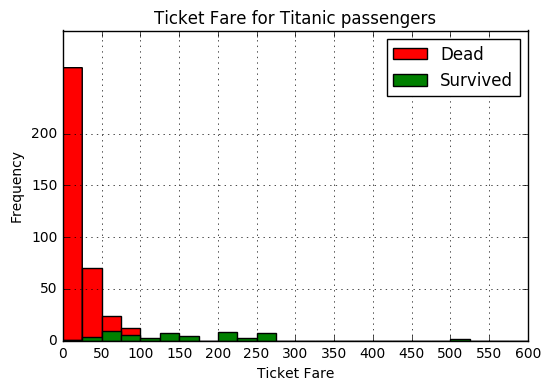

In [32]:
#split the test set into 2 dataframes based predictions of 0 and 1
test_grouped = titanic_test.groupby('Prediction')
dead = test_grouped.get_group(0)
survived = test_grouped.get_group(1)

xticks = np.arange(0,650,50)
yticks = np.arange(0,250,50)
binBoundaries = np.linspace(0,600,25)

plt.figure(5)
dead['Fare'].hist(bins = binBoundaries, label = 'Dead',color = 'r')
survived['Fare'].hist(bins = binBoundaries, label = 'Survived',color = 'g')
plt.title('Ticket Fare for Titanic passengers')
plt.xlabel('Ticket Fare')
plt.ylabel('Frequency')
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlim(0,600)
plt.legend()
plt.show()

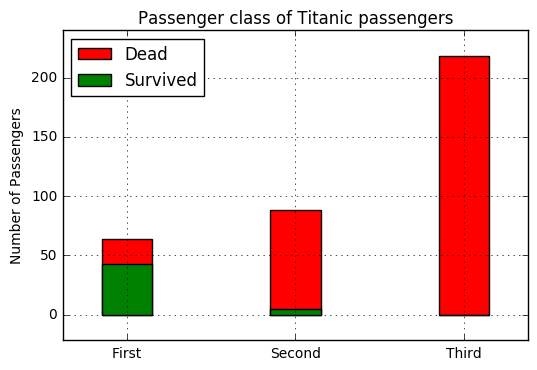

In [33]:
#divide dead and survived dataframe into first, second and third class
pclass_dead = dead.groupby('Pclass').size()
pclass_survived = survived.groupby('Pclass').size()

y1 = [pclass_dead.iloc[0],pclass_dead.iloc[1],pclass_dead.iloc[2]]
y2 = [pclass_survived.iloc[0],pclass_survived.iloc[1],0]

labels = ['First','Second','Third']
ngroups = 3
index = np.arange(ngroups)
barwidth = 0.3

plt.figure(6)
plt.bar(index, y1, barwidth, label = 'Dead', color = 'red')
plt.bar(index, y2, barwidth, label = 'Survived', color = 'green')
plt.xticks(index + 0.15, labels)
plt.legend(loc = 2)
plt.grid()
plt.title('Passenger class of Titanic passengers')
plt.ylabel('Number of Passengers')
plt.margins(0.1)
plt.show()

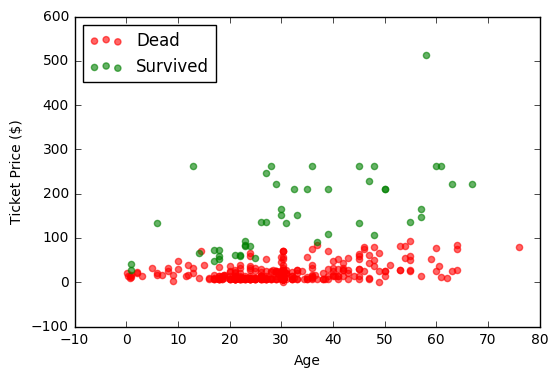

In [34]:
#analyzing scatter plot of the age vs the ticket price
#converting the dataframe columns into numpy arrays
dead_age = dead['Age']
dead_fare = dead['Fare']

survived_age = survived['Age']
survived_fare = survived['Fare']

plt.figure(7)
plt.scatter(dead_age, dead_fare, color = 'red', label = 'Dead', alpha = 0.6)
plt.scatter(survived_age, survived_fare, color = 'green', label = 'Survived', alpha = 0.6)
plt.xlabel('Age')
plt.ylabel('Ticket Price ($)')
plt.legend(loc = 2)
plt.show()